# **Clustering with K-Means and DBSCAN**

Laboratory 7 of the Machine Learning class by Prof. F. Chiariotti at University of Padova during academic year 2024-2025.

In [1]:
# importing all the necessary python libraries
%matplotlib inline  
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

# **Image segmentation**

In [2]:
np.random.seed(20) # setting the random seed

In [3]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    # function for plotting the input image
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    # function for plotting a scatter plot of the input data, given
    # - the data to plot
    # - the cluster labels
    # - the cluster centers
    # - the title of the plot
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    # function for plotting a 2D scatter plot of the input data, given:
    # - the data to plot
    # - the cluster labels
    # - the cluster centers
    # - the title of the plot
    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    # function for plottingt the input errors over the iterations of an algorithm 
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    # function for plotting the clusters obtained from the algorithm, given
    # - the cluster label
    # - the data
    # - the title of the plot
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1] # is removed and used for noise instead
        class_member_mask = (labels == k)
        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)
        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

## 1. **K-means clustering**

We want to use the k-means algorithm for image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color (i.e. vector of 3 (R,G, B) values, in a 3D space) with the closest representative color. This will allow us to reduce the number of colors in the image and compress it.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.


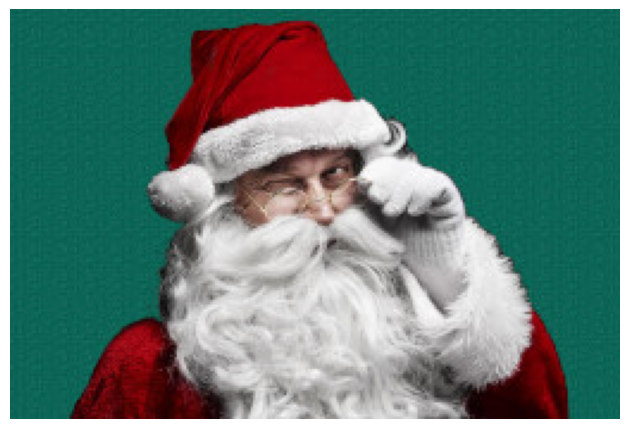

(172, 256, 3)


In [8]:
# loading and displaying the provided image and its size
santa = plt.imread("data/santaclaus2.jpg")
img_plot(santa)
print(santa.shape)

Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

shape: (44032, 3) min: 0.0 max: 1.0


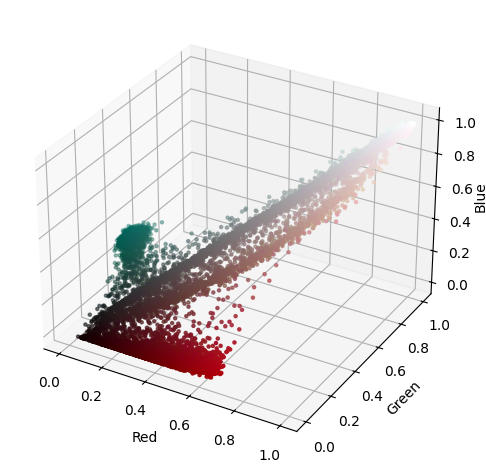

In [9]:
# reshaping the data to a matrix of num_pixels x 3 
santa_reshaped = np.reshape(santa, (santa.shape[0]*santa.shape[1],santa.shape[2]))
# shifting the range of colors from [0, 255] to [0,1]
santa_reshaped = santa_reshaped /255 
print("shape:",santa_reshaped.shape, "min:", np.min(santa_reshaped),"max:", np.max(santa_reshaped))
scatter_plot(santa_reshaped)

Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [10]:
def kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    # function for performing k-means clustering, given
    # - the data points
    # - the number of clusters k
    # - the maximum number of iterations

    # retrieving the means and standard deviation for each dimension to ensure a realistic description
    point_count = points.shape[0]
    coord_count = points.shape[1]
    data_means=[0]*coord_count
    data_devs=[0]*coord_count
    for coord in range(coord_count):
        data_means[coord] = np.mean(points[:,coord])
        data_devs[coord] = np.std(points[:,coord])

    centroids = np.ndarray((k,coord_count)) # generating random centroids 
    for num_centroid in range(k):
        for coord in range(coord_count):
            centroids[num_centroid, coord] = np.random.normal(data_means[coord], data_devs[coord])

    clusters = np.ndarray((point_count,))
    prev_error = 1e9+1
    error = [1e9]
    iters = 0 
    # until the estimate of the centroid is stable or the maximum number of iterations is reached
    while (error[iters] != prev_error) and iters < max_iters:
        distances = np.ndarray((point_count,k)) # measuring the distance from every centroid
        for point_num in range(point_count):
            for centroid_num in range(k):
                distances[point_num, centroid_num]=np.linalg.norm(points[point_num]-centroids[centroid_num])
        for point_num in range(point_count): # assigning each datum to the closest centroid
            clusters[point_num] = np.argmin(distances[point_num])
       
        for centroid_num in range(k): # calculating barycenter for every cluster
            for coord_num in range(coord_count):
                sum_for_avg = 0
                count_for_avg = 0
                for point_num in range(point_count):
                    if(clusters[point_num] == centroid_num):
                        count_for_avg += 1
                        sum_for_avg += points[point_num, coord_num]
                # updating the centroid (max is here to avoid potential "division by 0" errors)
                centroids[centroid_num, coord_num] = sum_for_avg/np.max([count_for_avg, 1]) 

        prev_error = error[iters] # updating the error
        current_error = 0 # average L2 loss
        for point_num in range(point_count):
            distances = [0]*coord_count
            for coord_num in range(coord_count):
                distances[coord_num] = points[point_num, coord_num] - centroids[int(clusters[point_num]), coord_num]
            current_error+=np.sum(np.square(distances))
        current_error /= point_count
        error.append(current_error)
        iters += 1 # updating the iteration counter

    return centroids, clusters, error

Now try the function you developed on the Santaclaus image with three clusters (k=3), then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids). Also, plot the total cost over each iteration

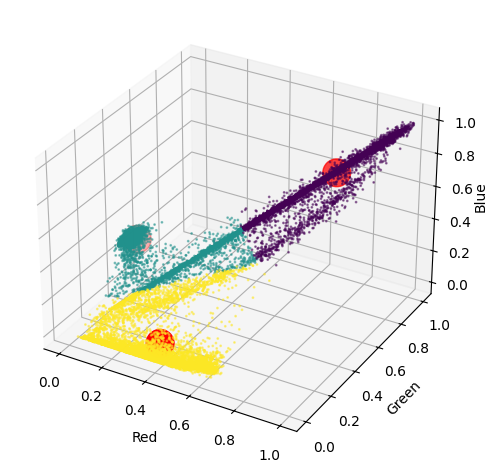

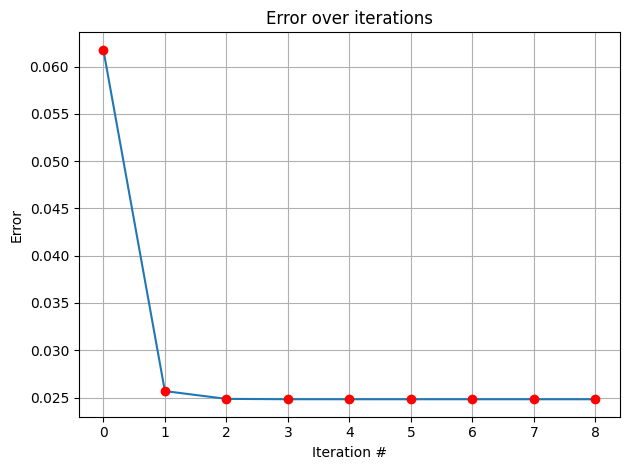

In [11]:
# running the scratch K-means function on the data for k=3
kmeans_centroids, kmeans_clusters, kmeans_errors = kmeans(santa_reshaped, k=3)
scatter_plot(santa_reshaped, kmeans_clusters, kmeans_centroids) # plotting the results
error_plot(kmeans_errors) # plotting the errors

Now compare your scratch implementation to the k-means function provided in SciKitLearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Perform the same plot as above but with the output of the k-means function provided in sklearn.

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, i.e. do the two plots match?

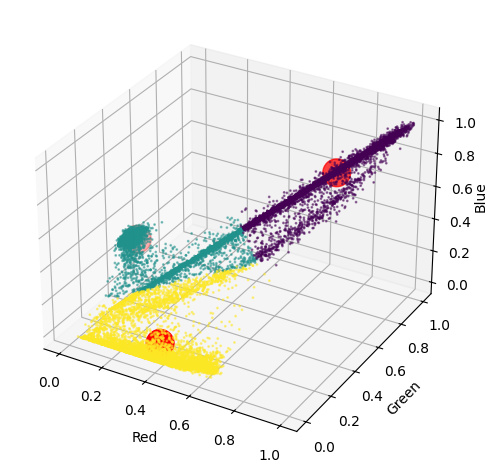

In [12]:
km = KMeans(n_clusters=3,n_init=100) # defining the k-means
santa_predicted = km.fit_predict(santa_reshaped) # fitting the model to the data
santa_reshaped_compressed = np.copy(santa_reshaped)
for i in range(santa_reshaped_compressed.shape[0]):
    santa_reshaped_compressed[i]=km.cluster_centers_[santa_predicted[i]]
centers = km.cluster_centers_ # getting the cluster center
scatter_plot(santa_reshaped, santa_predicted, centers) # plotting the results

The two plots are almost identical. The assignment to cluster numbers (the cluster ordering) is different, but this has to be expected since it is an unsupervised learning problem.

Now display the segmented image based on the clusters found above with the k-means functions by sklearn and by your own K-means implementation.

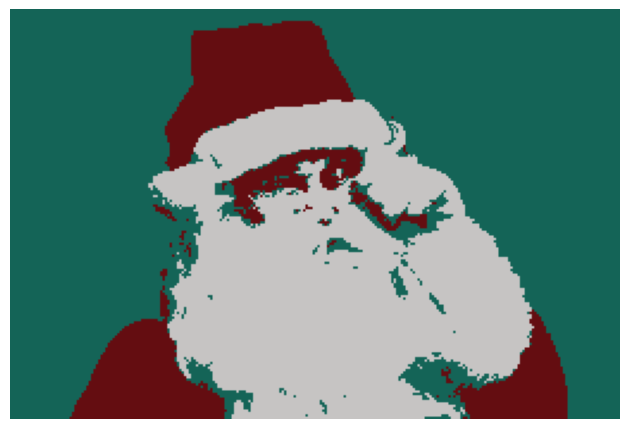

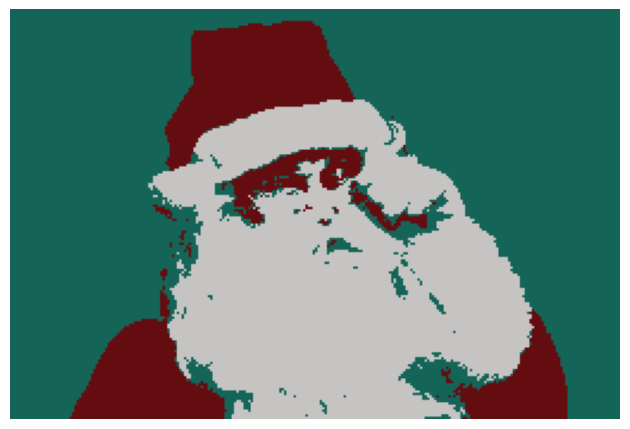

In [13]:
color_centers = centers*255 # extractingt the color values of the centers
# reshaping the data to the original image shape
santa_processed = np.reshape(santa_reshaped_compressed, santa.shape)
img_plot(santa_processed) # plottint the recolored image

kmeans_color_centers = kmeans_centroids*255 # extracting the color values of the centers
# reshaping the data to the original image shape
kmeans_santa_reshaped_compressed = np.copy(santa_reshaped)
for i in range(kmeans_santa_reshaped_compressed.shape[0]):
    kmeans_santa_reshaped_compressed[i]=kmeans_centroids[int(kmeans_clusters[i])]
kmeans_santa_processed = np.reshape(kmeans_santa_reshaped_compressed, santa.shape)
img_plot(kmeans_santa_processed) # plotting the recolored image

## 2. **DBSCAN clustering**

Now, we want to use a **linkage-based** clustering algorithm, DBSCAN, to cluster a dataset of 2D points and compare it with the results obtained with k-means.

Implement the algorithm with $\varepsilon=0.1$ and $M=10$ (i.e., the minimum number of neighbors). The output should be a list of indices for all points, indicating which cluster each point belongs to. Outliers are in cluster 0, all other points have a positive index. For efficiency, we should compute a distance matrix first. Additionally, since DBSCAN is much more complex, we will try it on a smaller dataset

In [14]:
data = np.load("data/moon_data.npz") # loading the dataset
x = data['X'] # extracting the data and labels
labels_true = data['labels_true'] 

In [15]:
def distance_matrix(points):
    # function for computing the pair-wise distances between all points in the dataset
    # it returns the distance matrix, which elements are the distances between pairs of points
    point_count = points.shape[0]
    distances = np.zeros((point_count, point_count))
    for i in range(point_count):
        array_points = np.asarray(points - points[i, :])
        distances[i, :] = np.linalg.norm(array_points,axis=1)
        # setting the diagonal distances as very large to avoid self loops during neighbor searches
        distances[i,i] = 1e9 
    return distances

def find_neighbors(distances, epsilon):
    # function for identifying the neighbords of a point based on the input distance matrix
    # and on the threshold epsilon, and returns the indeces of the neighboring points
    return np.where(distances < epsilon)[0]

def dbscan(points, epsilon, M):
    # function for implementing DBSCAN clustering, given
    # - the input points
    # - the maximum distance epsilon between two points to be considered neighbors
    # - the minimum number of neighbors (including the point itself) for having a core point
    point_count = points.shape[0] # initializing
    coord_count = points.shape[1]
    distances = distance_matrix(points)
    print(point_count)
    C = 0 # tracks the number of cluster currently found
    done = False
    clusters = -np.ones(point_count)
    while (not done):
        done = True
        for idx in range(point_count): # iterating through all points
            if (clusters[idx] < 0): # if a point is unassigned
                done = False # we are not done: we check its neighbourhood
                neighborhood = find_neighbors(distances[idx, :], epsilon)
                if (len(neighborhood) < M): # if there are not enough neighbours
                    clusters[idx] = 0 # it's classified as an outliers
                else: # if there are enough neighbours, it's a core point
                    C += 1 # one more cluster is found
                    clusters[idx] = C # the point is assigned to a cluster
                    done_cluster = False
                    while (not done_cluster): # its neighbourhood is checked (cluster expansion)
                        done_cluster = True
                        for next_idx in neighborhood:
                            if (clusters[next_idx] == 0): # if the neighbor is noise/outlier
                                done_cluster = False
                                clusters[next_idx] = C # it's assigned to the cluster
                            # if the neighbour is unassigned, we assign it to the current cluster cluster
                            if (clusters[next_idx] < 0): 
                                done_cluster = False
                                clusters[next_idx] = C
                                # and check its neighbourhoood
                                new_neighborhood = find_neighbors(distances[next_idx, :], epsilon)
                                if (len(new_neighborhood) >= M):
                                    # if the neighbour is a core point, we add it to the current neighbourhood
                                    neighborhood = list(set(neighborhood).union(new_neighborhood))                    
    return clusters

1500


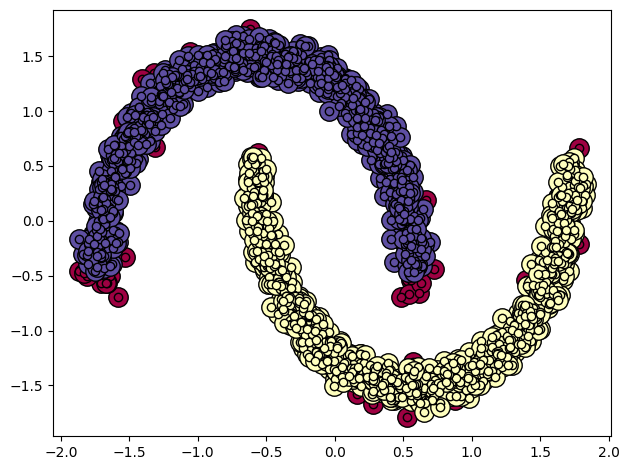

In [16]:
clusters = dbscan(x, epsilon=0.1, M=10) # plotting the results, with noise points in red
cluster_plot(clusters,x)